***Import libraires and data, set up stuff***

In [1]:
%run ../analysisLibraries

In [2]:
%matplotlib inline

In [3]:
%load_ext rpy2.ipython

In [4]:
import scanpySupport as scs

In [5]:
#for later automatization
#from os import environ
#n_genes = int( environ['n_genes'] ) #number of genes for normalization
#data_model_sct = str( environ['data_model_sct'] ) #model for data scTransform: 'nb' 'poisson'
#regul_mode = str( environ['regul_mode'] ) #regularization type for sct: 'std' 'latent' 'latent_nonreg'
#cores = int( environ['cores'] )
#if regul_mode=='std':
#    reg = 0
#elif regul_mode=='latent':
#    reg = 1
#else:
#    reg = 2
#reg=int(reg)

Load data. This example opens only one dataset, but if you have more than one preprocessed in the first notebook, then load them and do a concatenation before proceeding to scTransform normalization

In [5]:
adata_flt = sc.read('./write/qc/adata_05.h5ad')
#open more datasewts if anu

Run scTransfrom. Choose cores and memory to be used per core. eventually add latent variables to regress out, for example with the option

`latent=['total_counts','n_genes_by_counts']`

If you have loaded and concatenated more than one dataset after the first notebook, then use the option to keep batches into account, for example

`batch='batch'`.

Note that if batches are very similar or have some differing cell types, considering batches can sometimes mess it up. Eventually run everything again without considering batches and look into the resulting umap for an idea of how things worked

In [6]:
adata_flt = scs.pp.sctransform(adata=adata_flt,                    genes=5000, 
                   cores=4, memory=50,
                   method='poisson',
                   verbose=False)

Filtering genes
Configure future multithreading
Run scTransform
Running the command: vst_out=vst( as.matrix(rawMatrix), cell_attr=cell_df, n_genes=genes, method=method, show_progress=TRUE, min_cells=min_genes_per_cell, return_corrected_umi=TRUE, latent_var=c("data.scaled_CDR"))
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
Extract results


In [ ]:
!mkdir -p write/norm

In [7]:
adata_flt.write('./write/norm/adata_01.h5ad')

GLMpca on the data and normal PCA with UMAP plots for comparison. In general glmpca is pretty good, but very often standard pca works as well fine

In [17]:
adata_flt = sc.read('./write/norm/adata_01.h5ad')

In [8]:
adata_flt.X = adata_flt.layers['norm_sct'].copy()

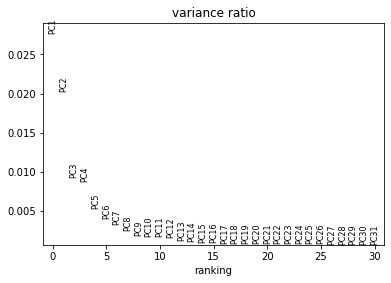

In [9]:
sc.pp.scale(adata_flt)
sc.pp.pca(adata_flt, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_flt)

In [10]:
#standard PCA
adata_flt.obsm['X_pca_std'] = adata_flt.obsm['X_pca'].copy()
sc.pp.neighbors(adata_flt, n_pcs=15)
sc.tl.umap(adata_flt)

In [ ]:
sc.pl.umap(adata_flt)

In [15]:
adata_flt.write('./write/norm/adata_02.h5ad')

### GLMPCA with batch covariate

In [16]:
adata_flt = sc.read('./write/norm/adata_02.h5ad')

In [17]:
#use only HVGs or it takes ages to run with more or less similar results but more noisy
adata_glmpca = adata_flt[:,adata_flt.var['highly_variable']].copy()

In [33]:
#here you can define important covariates. For categories, rename covariates into integers by creating an array (as in batchVec below for batch categories). Create an array (X_glm) with as many columns as needed covariates, and put the arrays as columns.

#batchVec = np.asarray(adata_glmpca.obs['batch'])
#batchVec[batchVec=='PLA_1'] = 0
#batchVec[batchVec=='PLA_2'] = 1
#X_glm = np.zeros((adata_glmpca.shape[0],1))
#X_glm[:,0] = batchVec

#Use the option X=X_glm in `glmpca.glmpca`.

In [18]:
Y = adata_glmpca.layers['umi_corr'].T.todense().copy()
Y = np.asarray(Y)
from glmpca import glmpca
try:
    res = glmpca.glmpca(Y, 15, penalty=1)
    factors = res["factors"]
    adata_glmpca.obsm['X_glmpca']=factors
    adata_glmpca.obsm['X_pca']=factors
    adata_flt.obsm['X_glmpca'] =        adata_glmpca.obsm['X_glmpca'].copy()
except: #if glmpca does not converge, use just pca
    print("glmpca failed. Try with higher penalty, or removing/adding important covariates, or look at how classical pca is working.")
    sc.pp.pca(adata_glmpca, svd_solver='arpack')

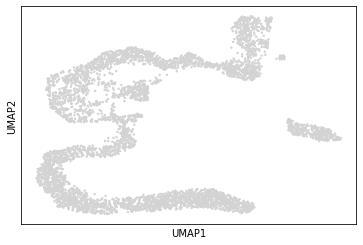

In [19]:
#if you have batches, use the function
#sc.external.pp.bbknn(adata_glmpca) to calculate neighbourhood. You have to install bbknn.
sc.pp.neighbors(adata_glmpca) 
sc.tl.umap(adata_glmpca)
sc.pl.umap(adata_glmpca)

In [20]:
adata_flt.write('./write/norm/adata_03.h5ad')